## Inspection code for TFFTX models
(run this from the notebooks folder)

In [1]:
import teafacto as tea, re, pandas as pd, seaborn as sns, numpy as np
from teafacto.scripts import tfftx
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
#m = tfftx.loadmodel("../models/tfftx.2015-12-03=20:31") # TFSGDC 10 dim 10 iter rhs sampling
#m = tfftx.loadmodel("../models/tfftx.2015-12-03=20:53") # TFSGDC 10 dim 10 iter full sampling
m = tfftx.loadmodel("../models/TFMXSGDC.2015-12-04=00:05.auto")
xd, yd, zd = tfftx.loaddicts("../data/nycfilms/fulltensorext.apx.pkl")


### Direct compatibility between entities and relations

In [12]:
prefixes = {"dbo": "http://dbpedia.org/ontology/",
            "dbr": "http://dbpedia.org/resource/",
            "dbp": "http://dbpedia.org/property/"}
ents = ["dbr:Grace_Kelly",  
        "dbr:Alfred_Hitchcock",
        "dbr:Alma_Reville",
        "dbr:Emma_Stone",
        "dbr:Oliver_Stone",
        "dbr:Hans_Zimmer",
        "dbr:Rear_Window",
        "dbr:Avengers:_Age_of_Ultron", 
        "dbr:New_York_City",
        "dbr:Lviv", 
        "dbr:United_States",
        "dbr:Sony_Pictures_Entertainment",
        "dbr:Warner_Bros.",
        "dbr:Paramount_Pictures"]
rels = ["dbo:spouse", "-dbo:spouse",
        "dbp:spouse", "-dbp:spouse",
        "dbo:birthPlace", "-dbo:birthPlace",
        "dbo:location", "-dbo:location",
        "dbo:foundedBy","-dbo:foundedBy",
        "dbo:director", "-dbo:director",
        "dbo:producer", "-dbo:producer",
        "dbo:starring", "-dbo:starring",
        "dbo:country", "-dbo:country",
        "dbo:musicComposer", "-dbo:musicComposer"]

In [14]:
prefixre = "(\-?)(\w+):(.*)"
prefixre = re.compile(prefixre)

In [15]:
def dopre(es, prefixes):
    m = prefixre.match(es)
    return m.group(1) + prefixes[m.group(2)] + m.group(3)

def computemetric(e, r, f, xdd, ydd):
    eid = xdd[dopre(e, prefixes)]
    rid = ydd[dopre(r, prefixes)]
    return f(eid, rid)

In [22]:
print yd[dopre("dbo:spouse", prefixes)] - yd[dopre("-dbo:spouse", prefixes)]
print yd[dopre("dbo:location", prefixes)] - yd[dopre("-dbo:location", prefixes)]
for rel in rels:
    print yd[dopre(rel, prefixes)]

-501
-501
27
528
21
522
4
505
45
546
409
910
31
532
26
527
14
515
37
538
56
557


In [17]:
todf = []
for ent in ents:
    row = []
    for rel in rels:
        row.append(computemetric(ent, rel, m.embedXYcos, xd, yd))
    todf.append(row)

In [18]:
df = pd.DataFrame(todf)
df.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)
df.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)

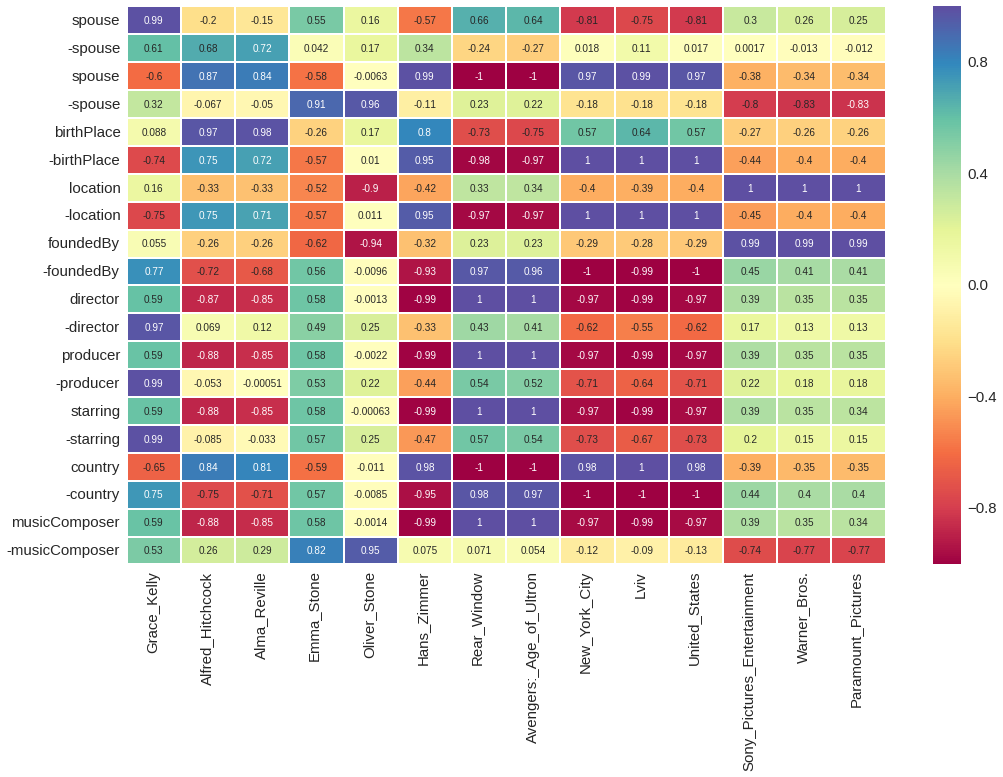

In [19]:
sns.set_context("notebook", font_scale=1.5)
f, ax = plt.subplots(figsize=(17,10))
sns.heatmap(df.T, annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

### Trans-compatibility

In [228]:
trels = [
    "dbo:spouse",
    "dbo:birthPlace",
    "dbo:location",
    "dbo:foundedBy",
    "dbo:producer",
    "dbo:director",
    "dbo:starring",
    "dbo:musicComposer",
    "-dbo:spouse",
    "-dbo:birthPlace",
    "-dbo:location",
    "-dbo:foundedBy",
    "-dbo:producer",
    "-dbo:director",
    "-dbo:starring",
    "-dbo:musicComposer",
]

In [229]:
def computeZXYmetric(t, e, r, f):
    tid = zd[dopre(t, prefixes)]
    eid = xd[dopre(e, prefixes)]
    rid = yd[dopre(r, prefixes)]
    return f(tid, eid, rid)

In [230]:
tdfs = {}
for trel in trels:
    totdf = []
    for ent in ents:
        row = []
        for rel in rels:
            row.append(computeZXYmetric(trel, ent, rel, m.embedXYZdot))
        totdf.append(row)
    tdf = pd.DataFrame(totdf)
    tdf.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)
    tdf.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)
    tdfs[trel] = tdf


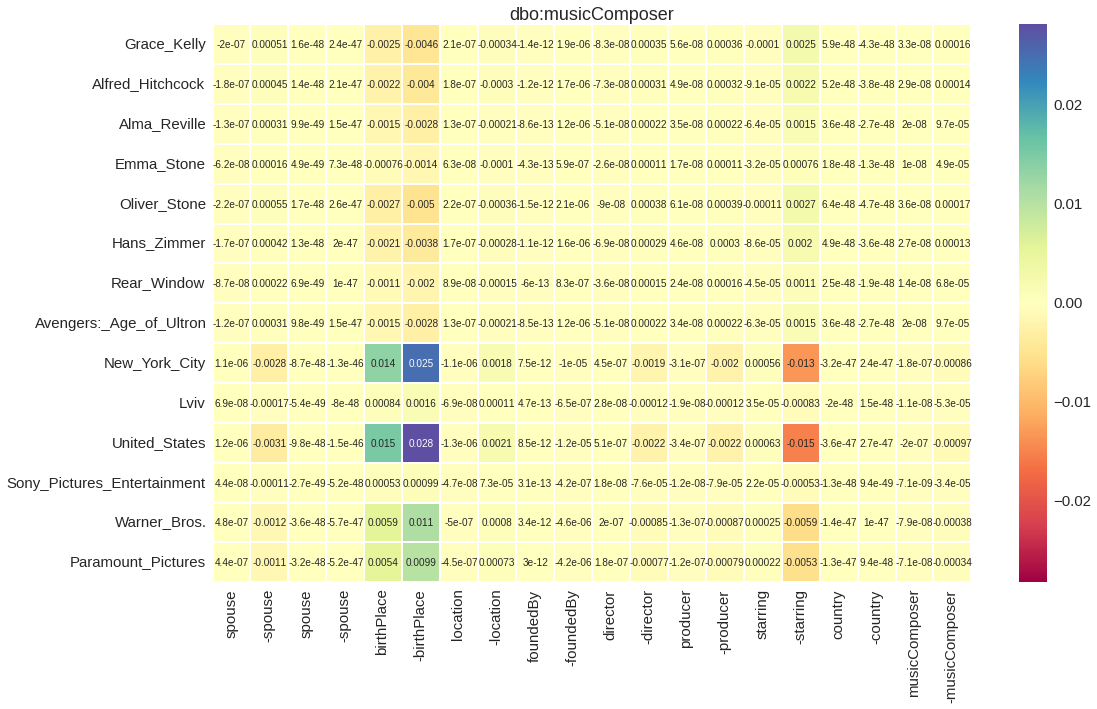

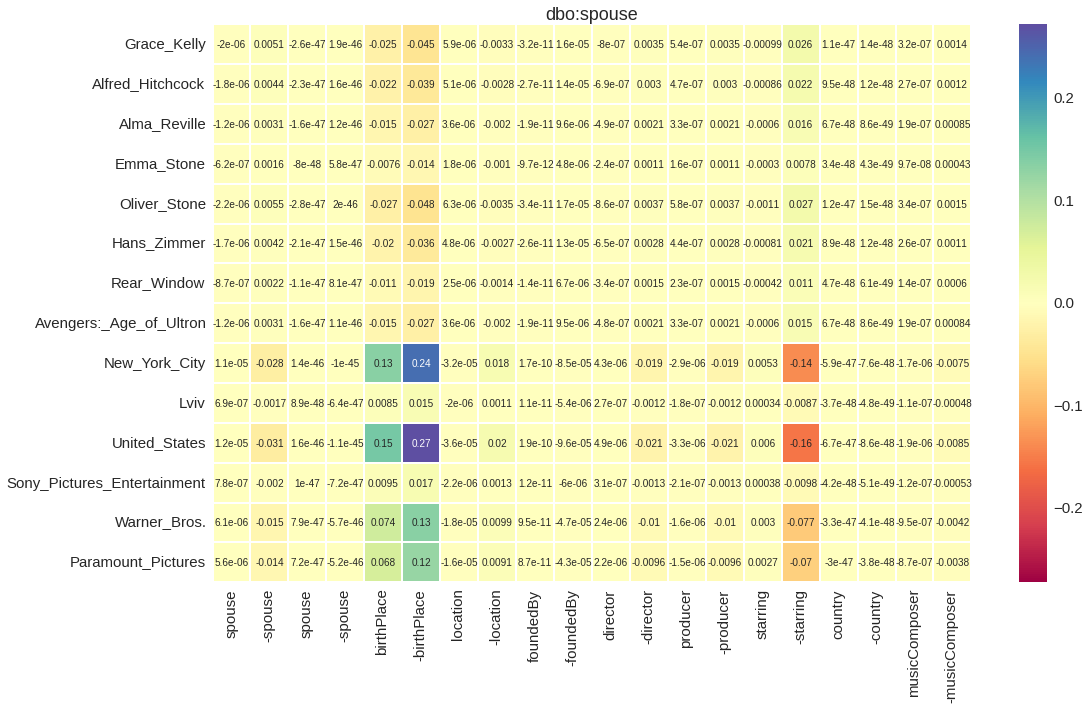

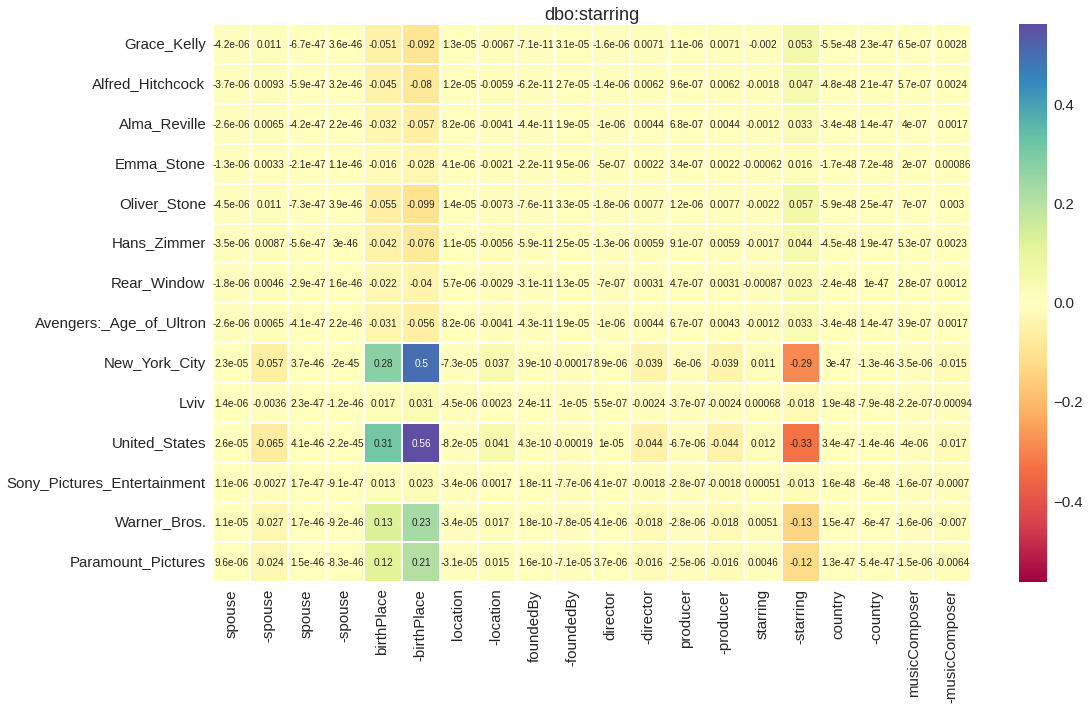

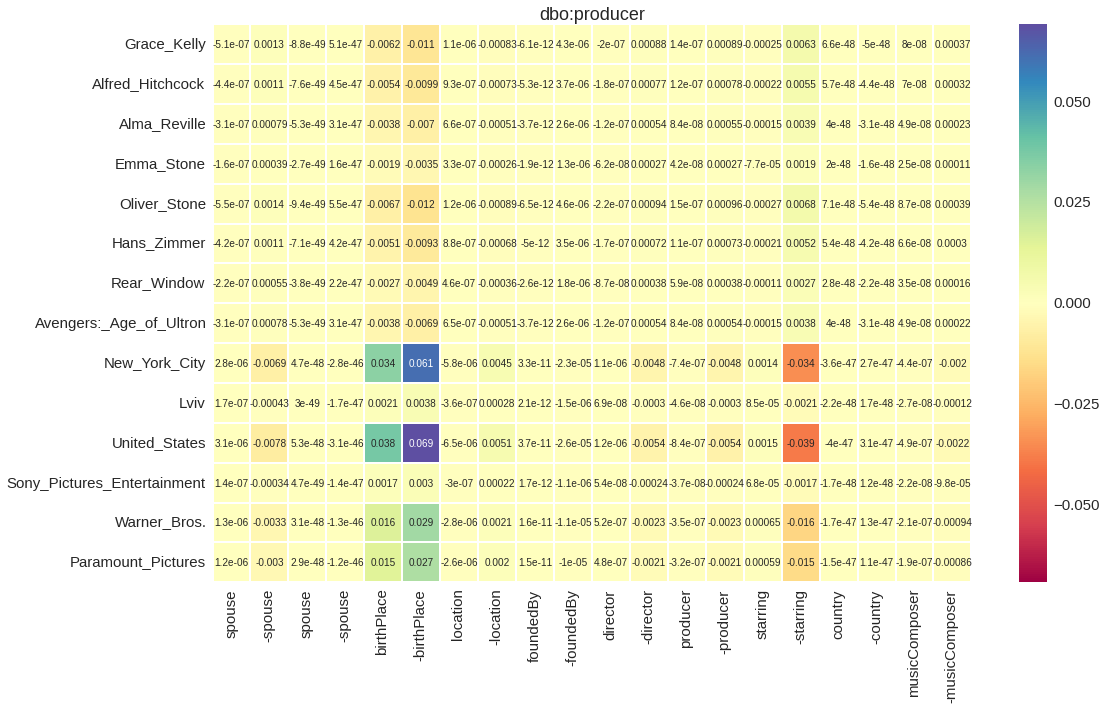

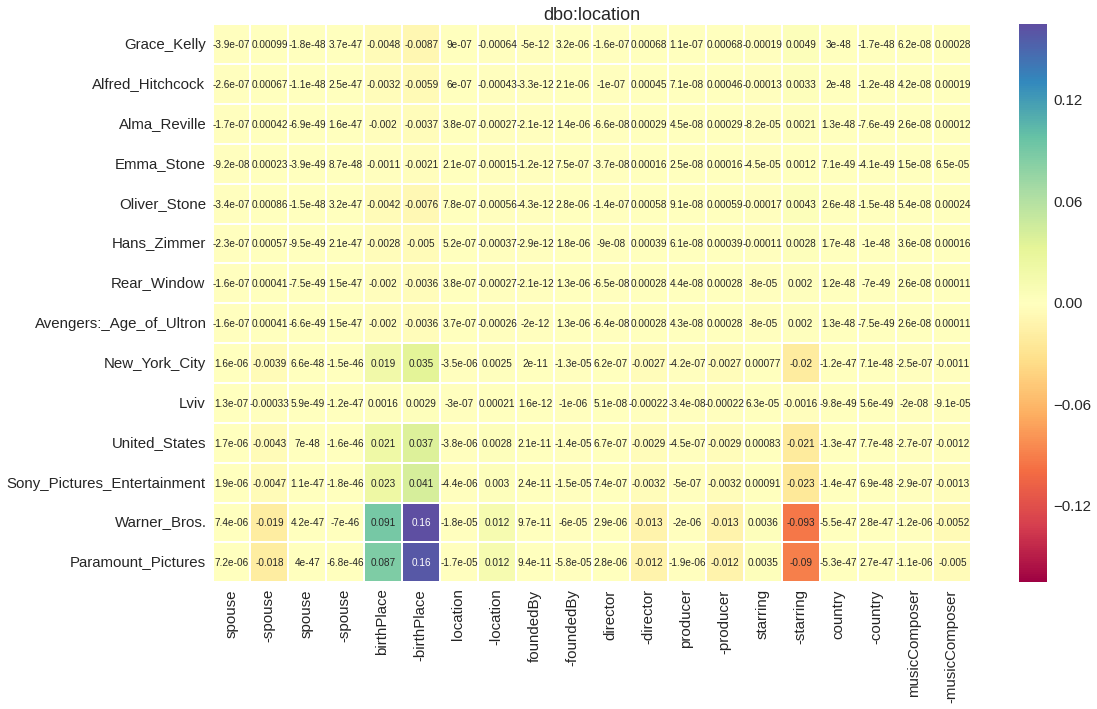

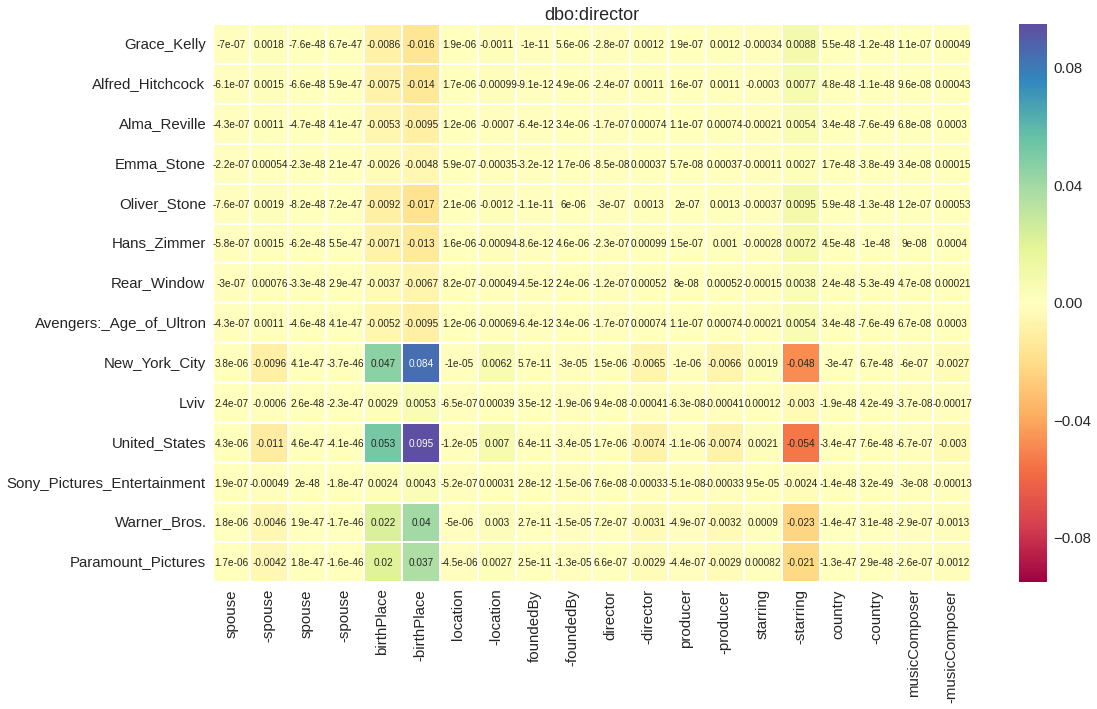

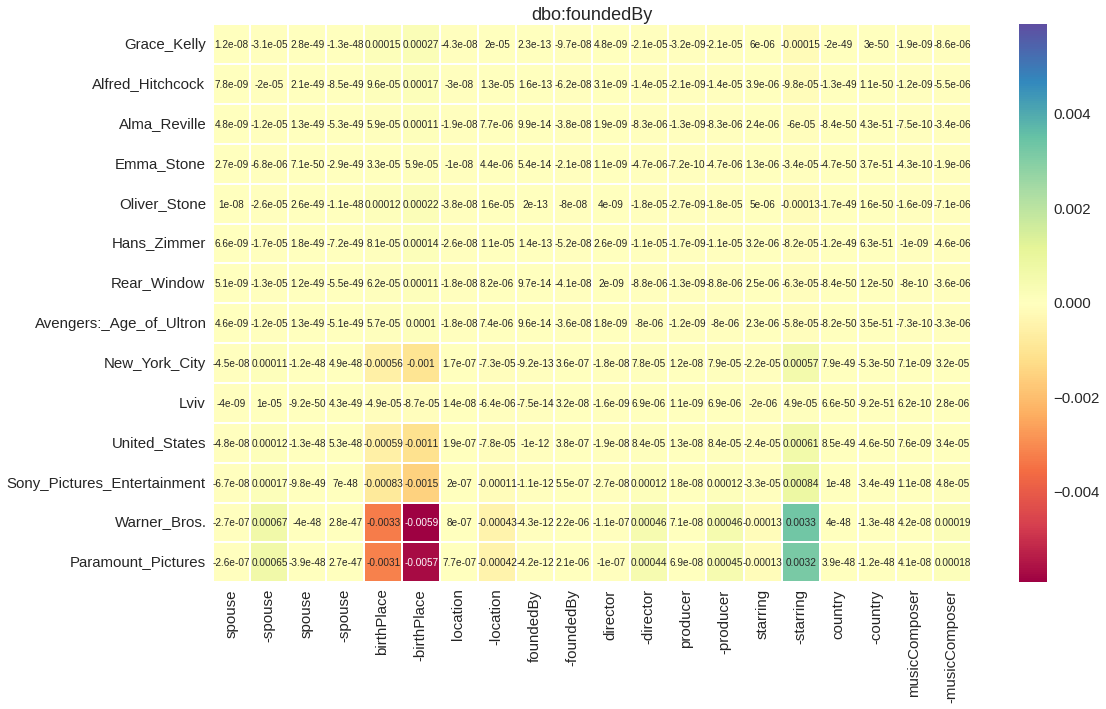

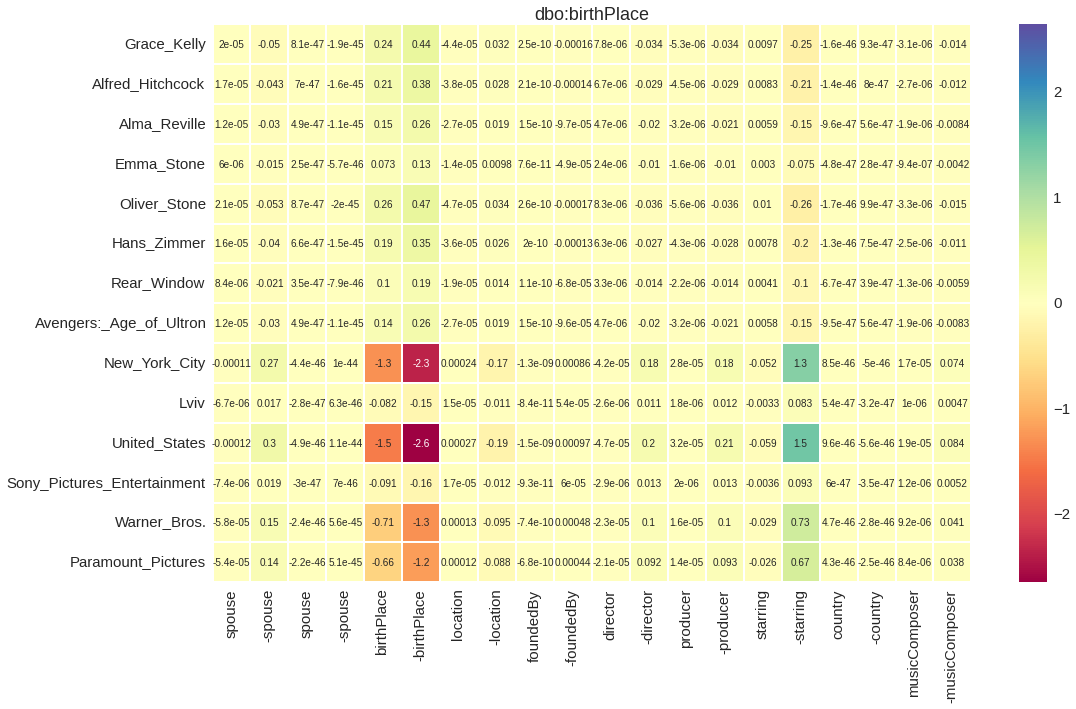

In [231]:
for tdf in tdfs:
    f, ax = plt.subplots(figsize=(17,10))
    ax.set_title(tdf)
    hm = sns.heatmap(tdfs[tdf], annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

### Chains compat (trans-trans-compat): TODO

In [215]:
chains = [
    ["dbo:spouse", "dbo:birthPlace"],
    ["dbo:producer", "dbo:birthPlace"],
    ["-dbo:producer", "dbo:starring"],
    ["-dbo:starring", "dbo:producer"],
    ["dbo:director", "-dbo:producer"],
    ["-dbo:musicComposer", "dbo:director"],
    ["-dbo:birthPlace", "-dbo:director"]
]

In [125]:
def computeZZXYdot(t, tt, e, r, m):
    eid = xd[dopre(e, prefixes)]
    rid = yd[dopre(r, prefixes)]
    tid = zd[dopre(t, prefixes)]
    ttid = zd[dopre(t, prefixes)]
    evec = m.embedX(eid)
    rvec = m.embedY(rid)
    tvec = m.embedZ(tid)
    ttvec = m.embedZ(ttid)
    vec = evec
    tvecchain = [tvec, ttvec]
    for tvecc in tvecchain:
        vec = tfftx.transform(vec, tvecc)
    return tfftx.getcompat(vec, rvec)

In [126]:
ttdfs = {}
for chain in chains:
    tottdf = []
    for ent in ents:
        row = []
        for rel in rels:
            row.append(computeZZXYdot(chain[0], chain[1], ent, rel, m))
        tottdf.append(row)
    ttdf = pd.DataFrame(tottdf)
    ttdf.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)
    ttdf.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)
    ttdfs[tuple(chain)] = ttdf


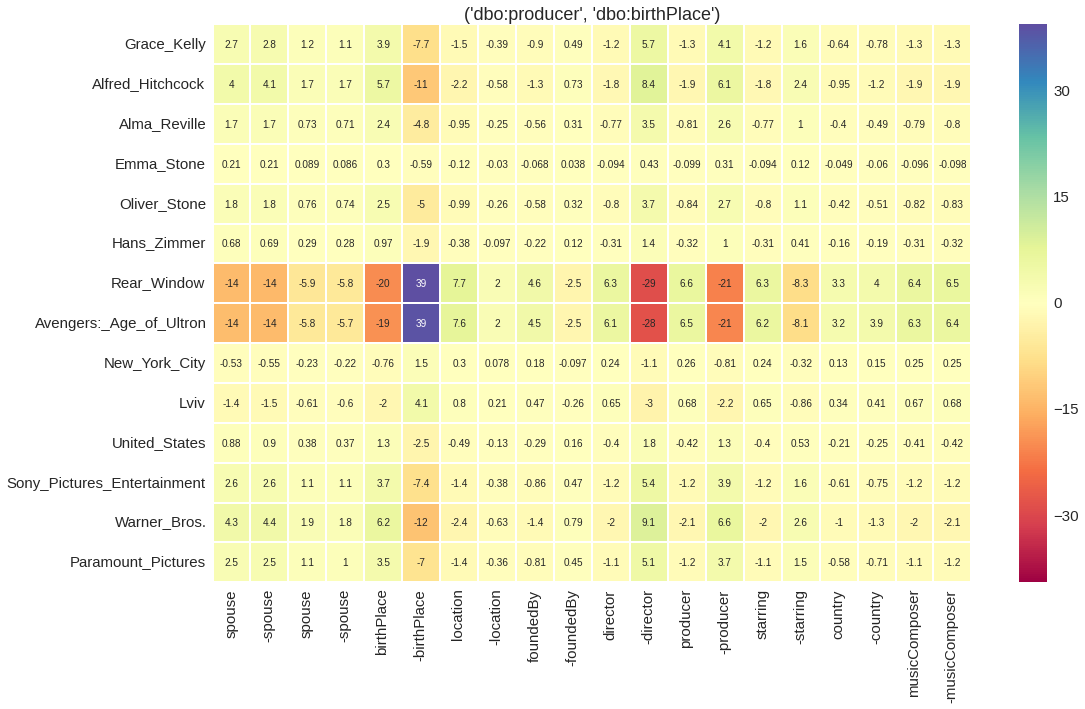

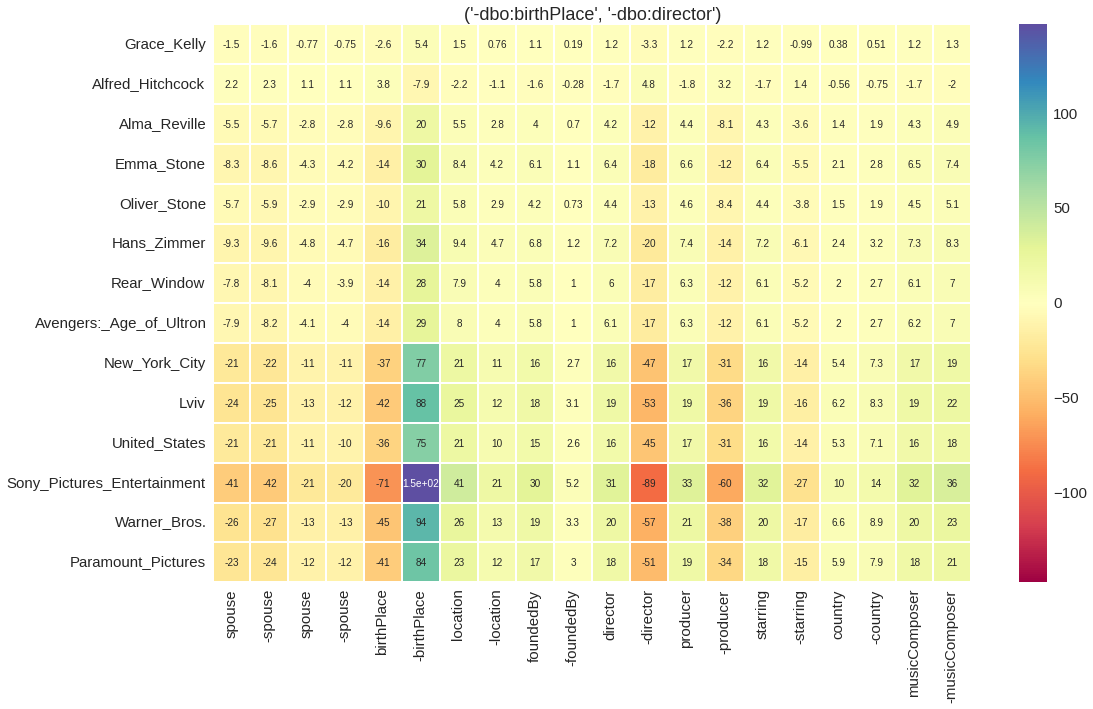

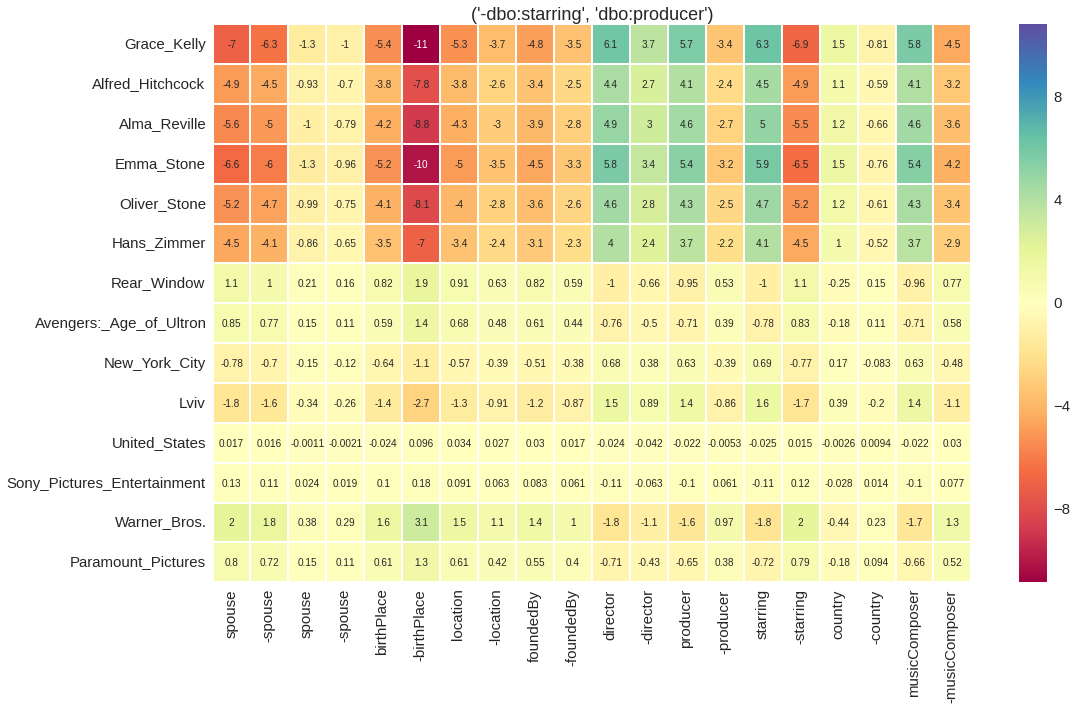

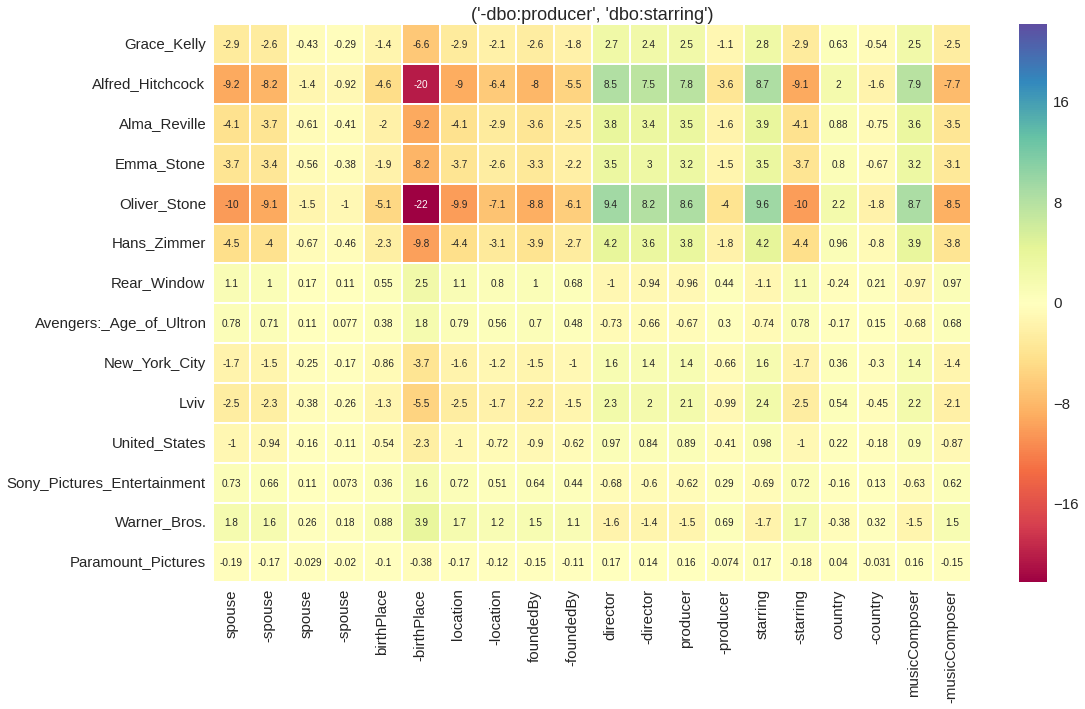

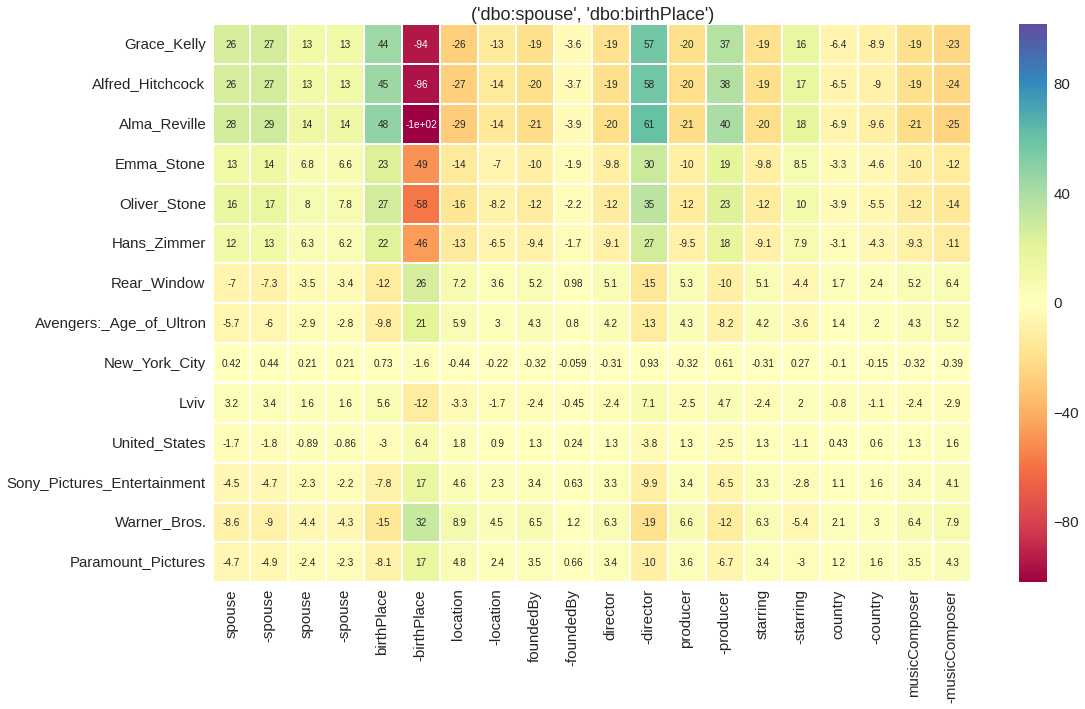

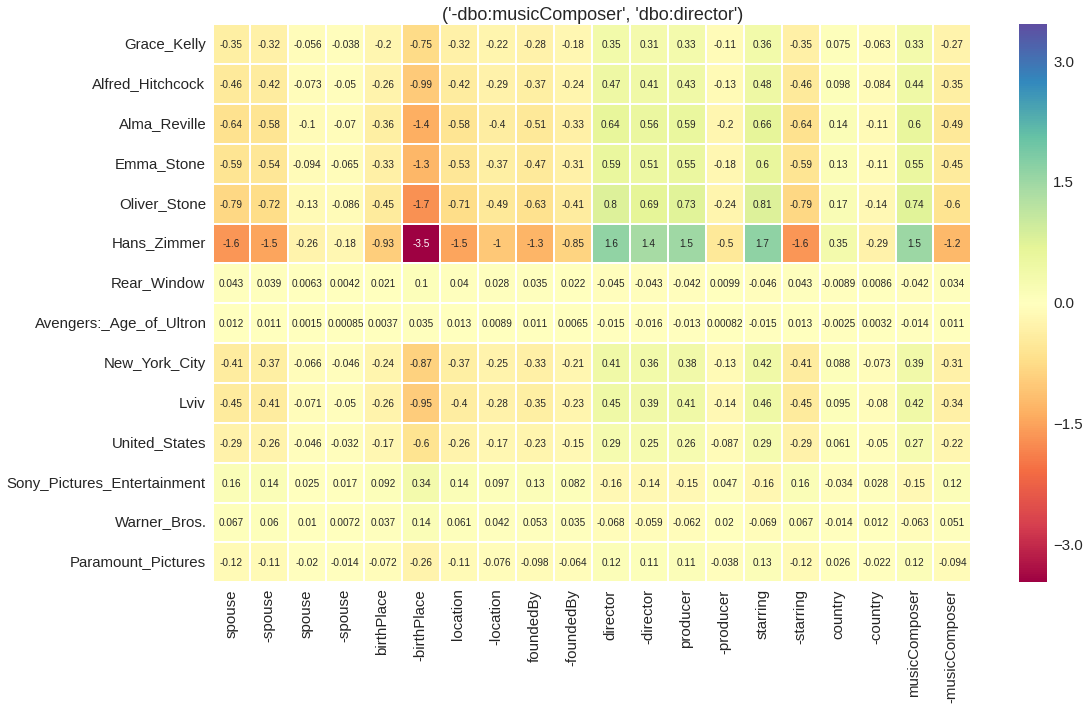

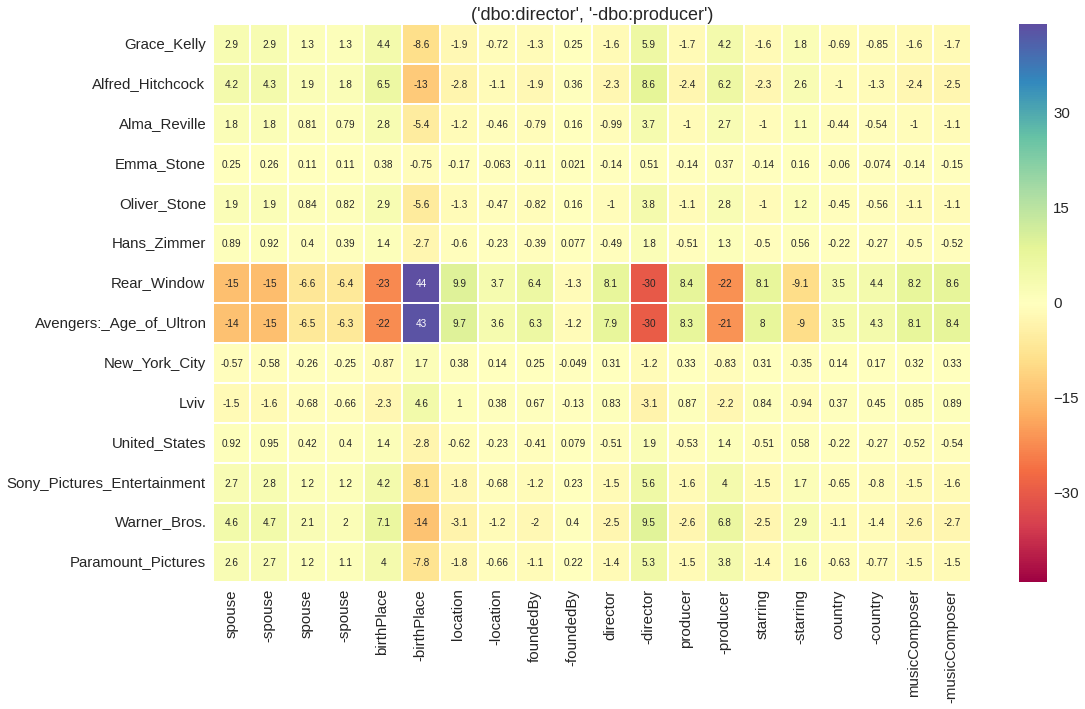

In [127]:
for ttdf in ttdfs:
    f, ax = plt.subplots(figsize=(17,10))
    ax.set_title(ttdf)
    hm = sns.heatmap(ttdfs[ttdf], annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

### Relation-relation compat

In [128]:
rtodf = []
for rel in rels:
    row = []
    for rel2 in rels:
        row.append(computemetric(rel, rel2, m.embedYYcos, yd, yd))
    rtodf.append(row)

rdf = pd.DataFrame(rtodf)
rdf.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)
rdf.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)

In [129]:
mask = np.ones(rdf.shape,dtype='bool')
mask[np.tril_indices(len(rdf))] = False
rdf = rdf.mask(mask)

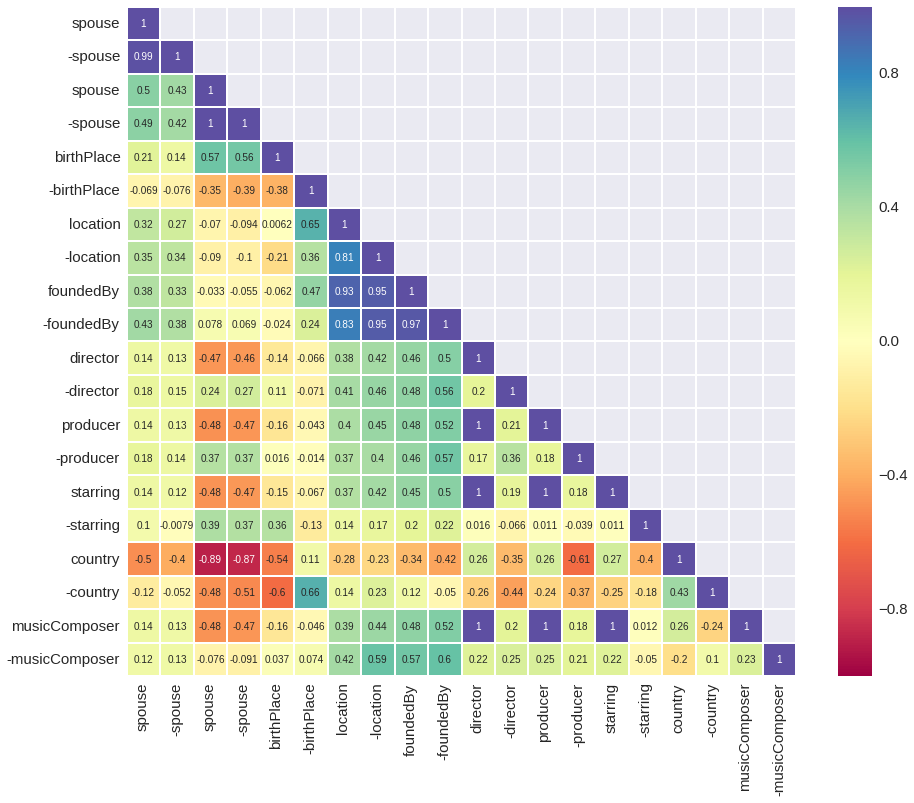

In [130]:
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(rdf, annot=True, linewidths=1.0, ax=ax, cmap="Spectral", square=True)

### Entity-entity compat

In [171]:
etodf = []
for ent in ents:
    row = []
    for ent2 in ents:
        row.append(computemetric(ent, ent2, m.embedXXcos, xd, xd))
    etodf.append(row)

edf = pd.DataFrame(etodf)
edf.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)
edf.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)

In [172]:
mask = np.ones(edf.shape,dtype='bool')
mask[np.tril_indices(len(edf))] = False
edf = edf.mask(mask)

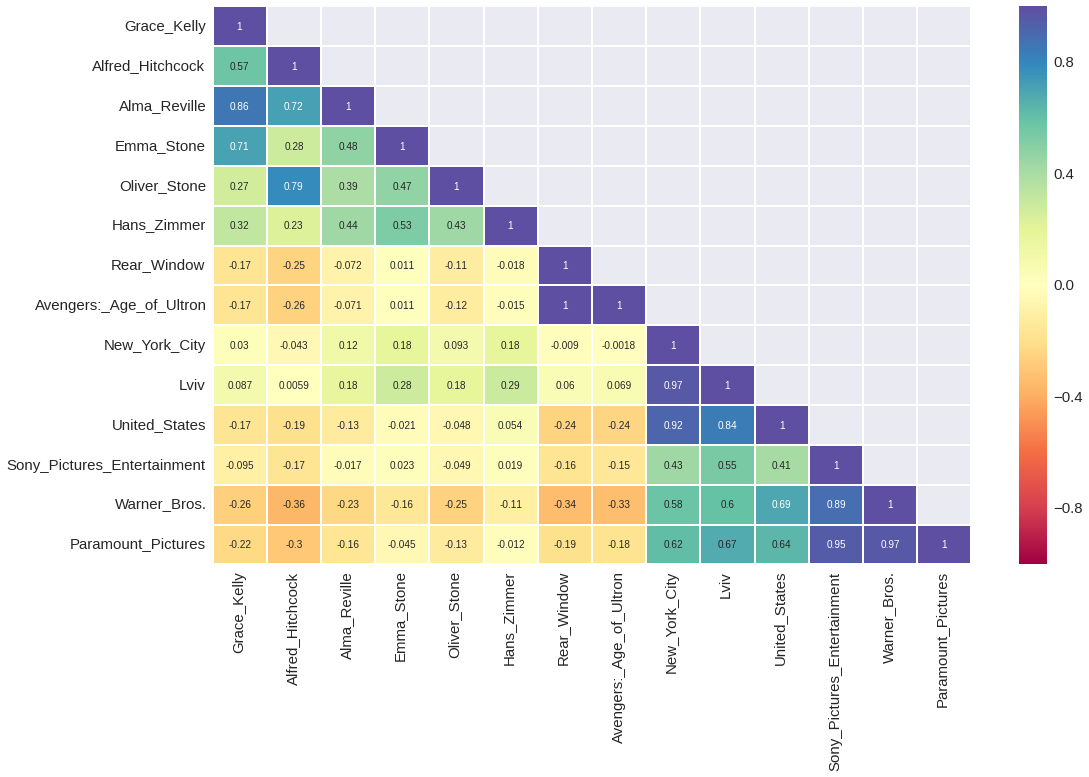

In [173]:
f, ax = plt.subplots(figsize=(17,10))
sns.heatmap(edf, annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

#### What do entities look like?

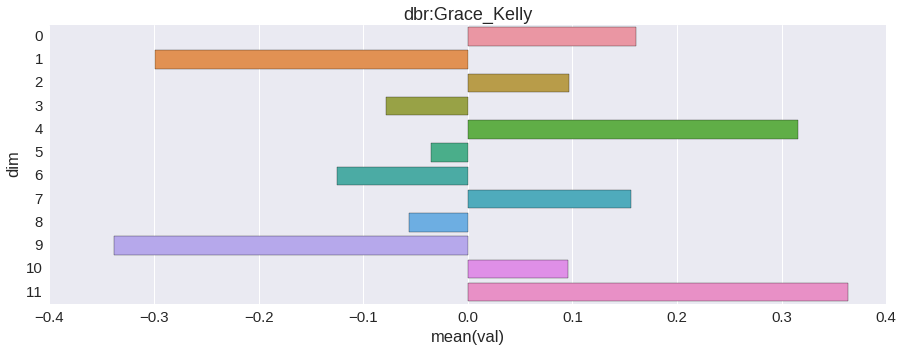

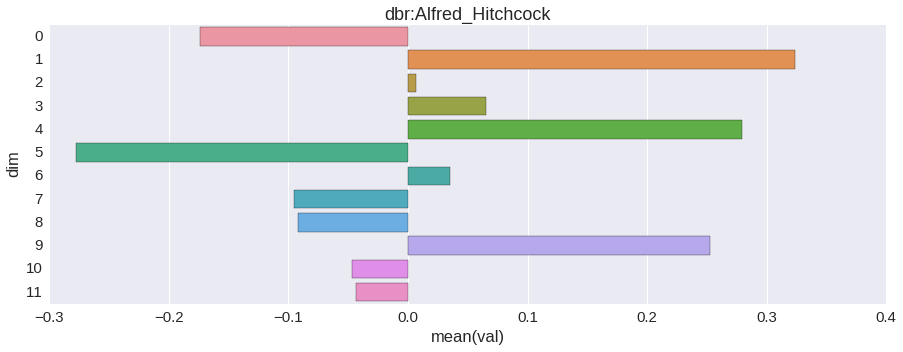

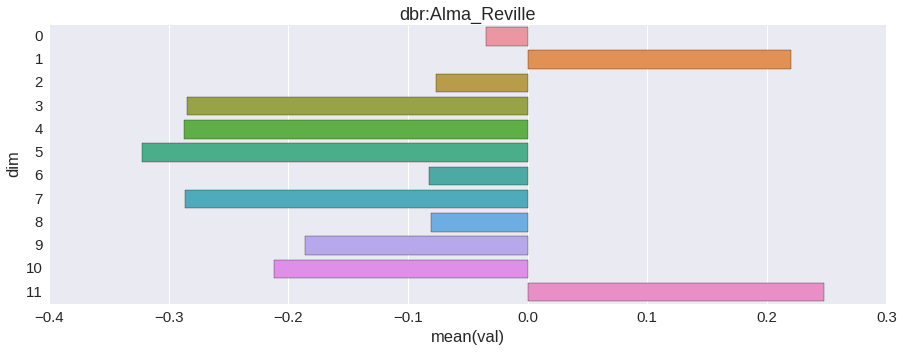

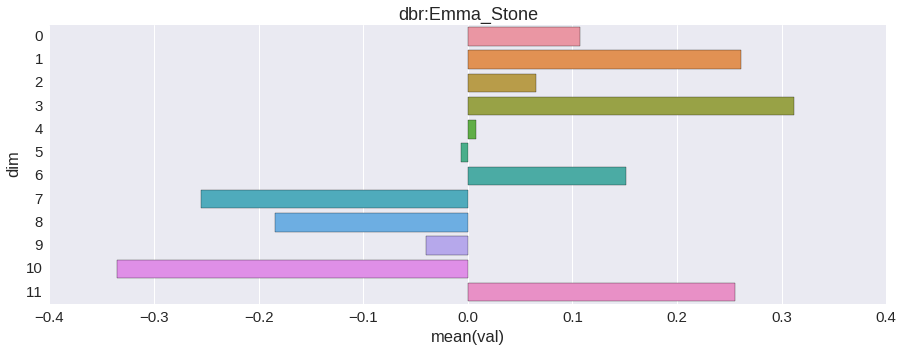

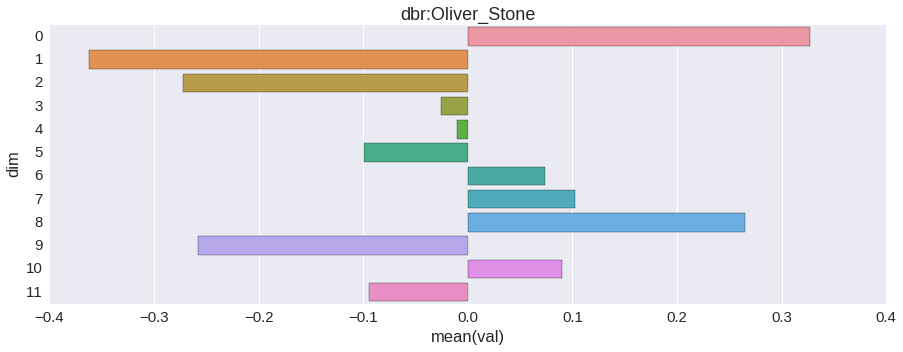

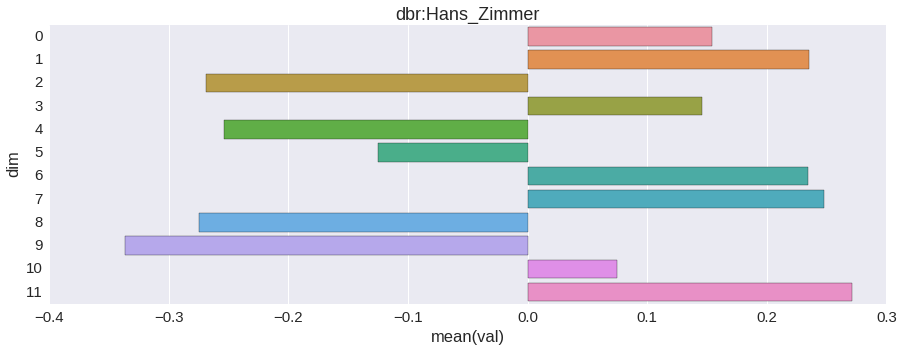

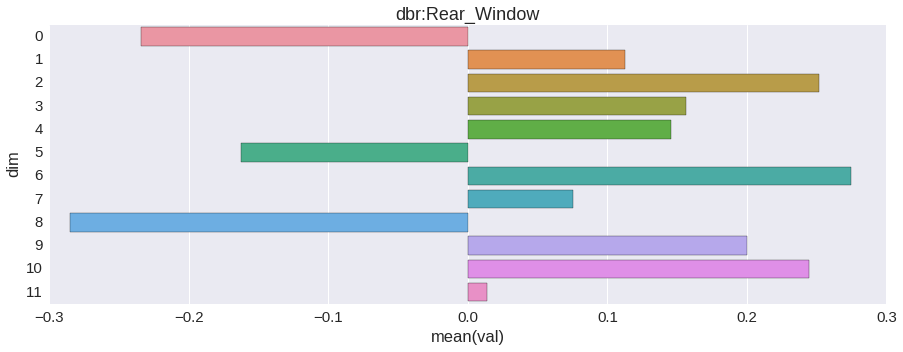

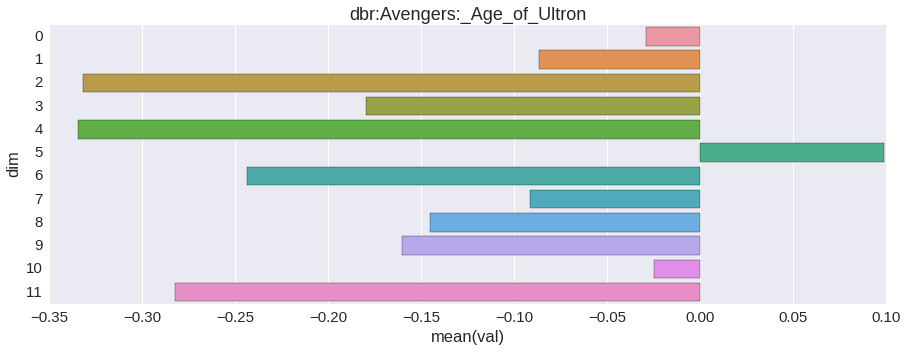

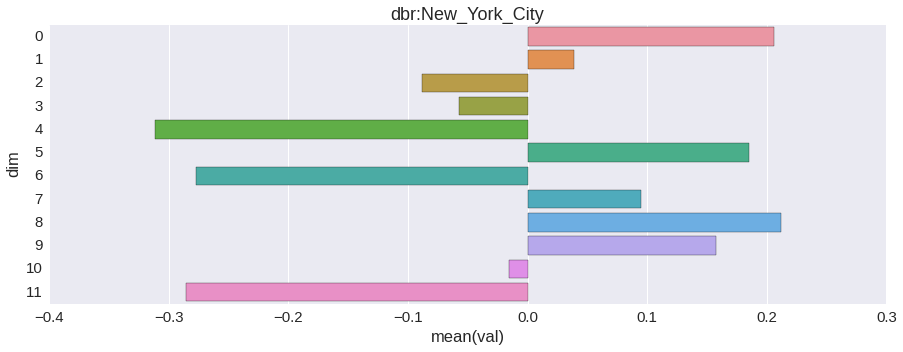

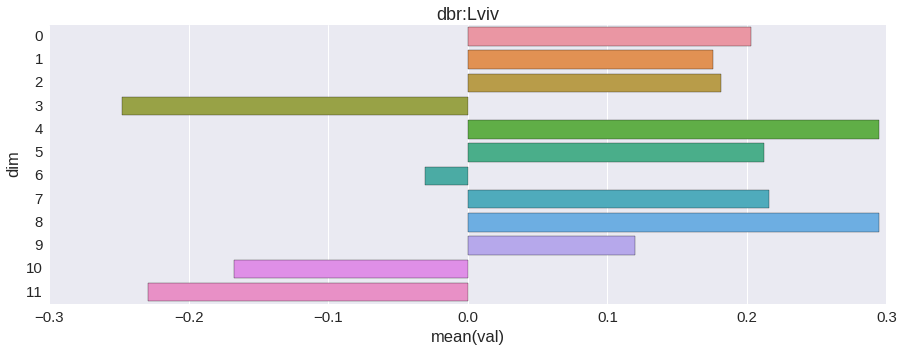

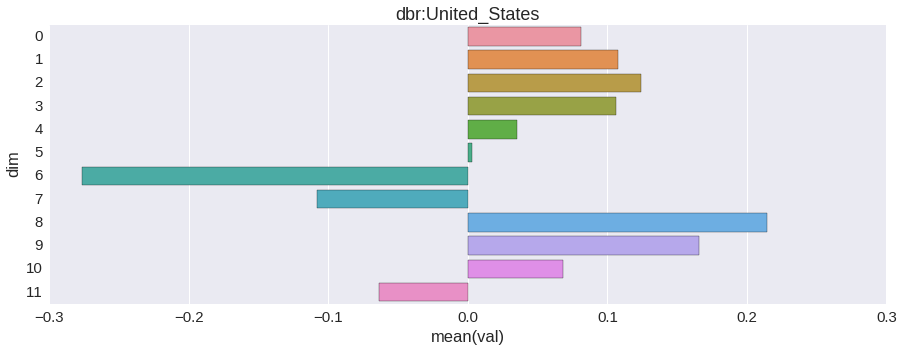

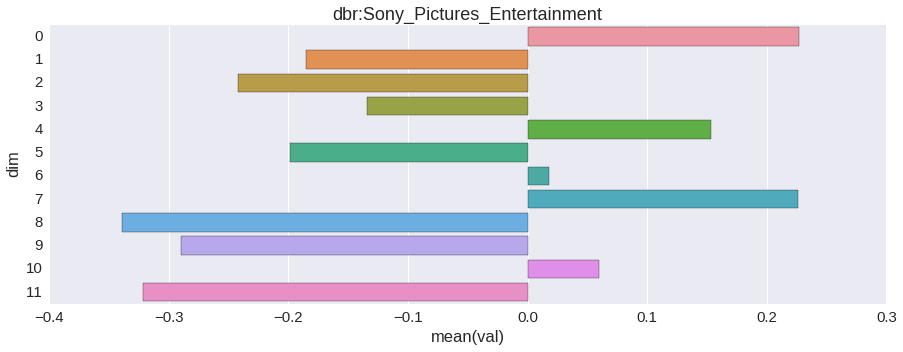

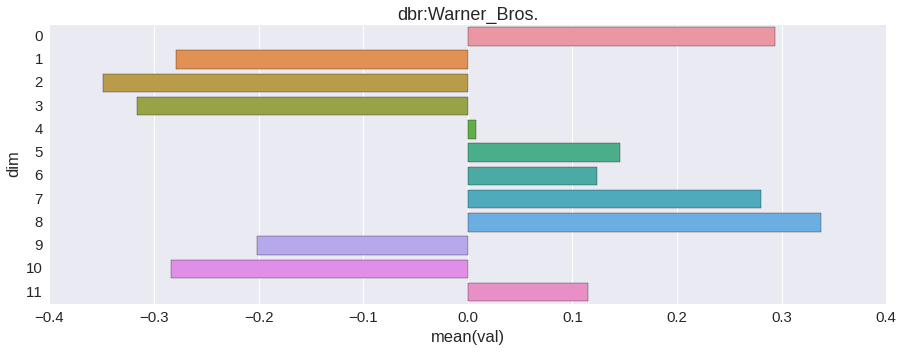

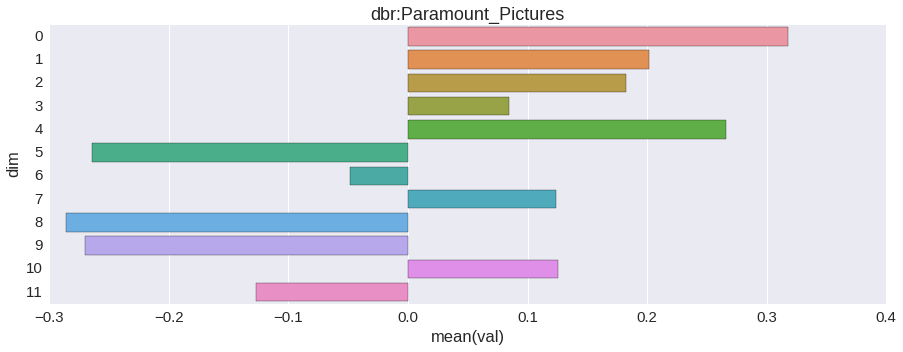

In [184]:

for ent in ents:
    entemb = m.embedX(xd[dopre(ent, prefixes)])
    entembdf = pd.DataFrame(zip(range(len(entemb)), entemb), columns=["dim", "val"])
    f, ax = plt.subplots(figsize=(15,5))
    ax.set_title(ent)
    sns.barplot(x="val", y="dim", data=entembdf, ax=ax, orient="h")

#### What do relations look like?

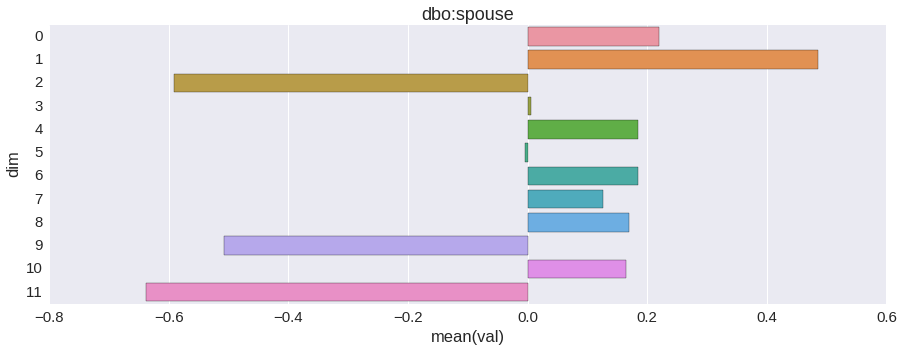

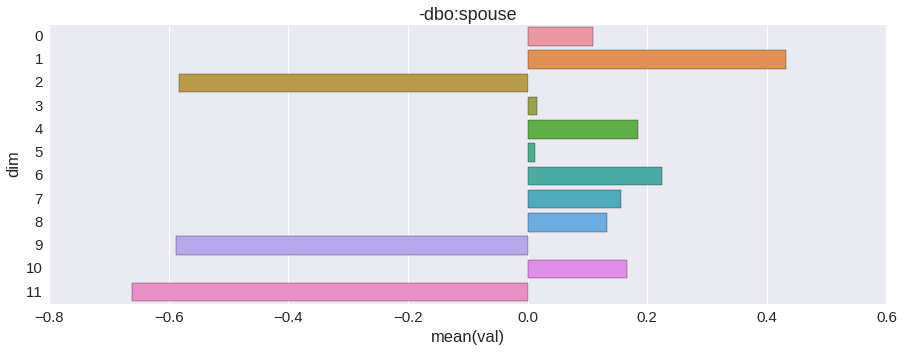

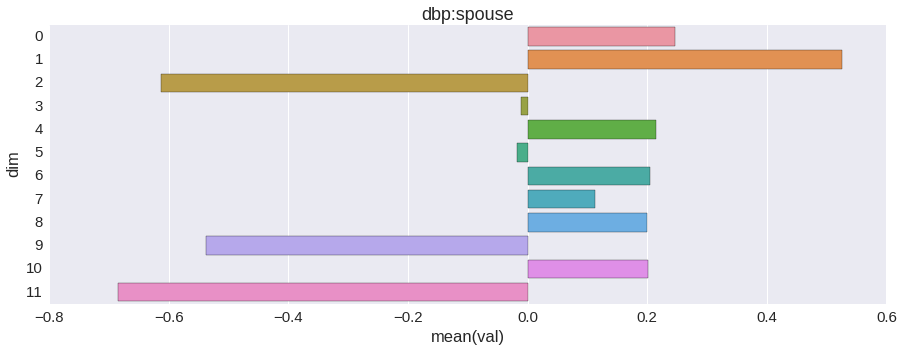

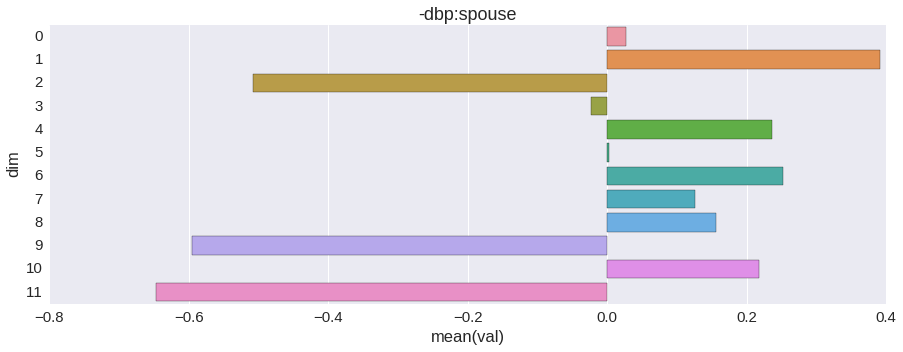

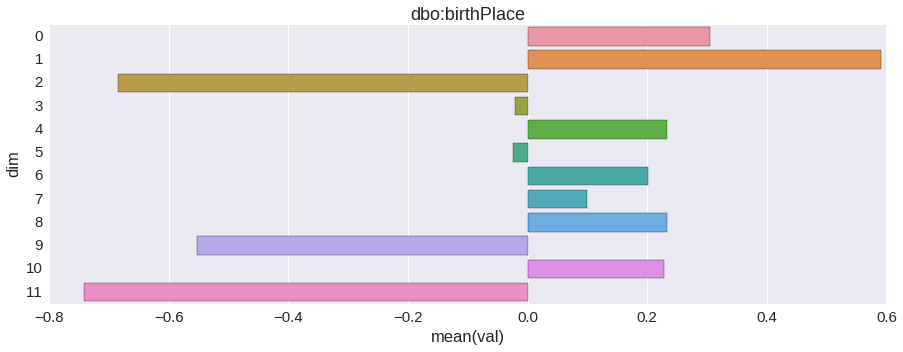

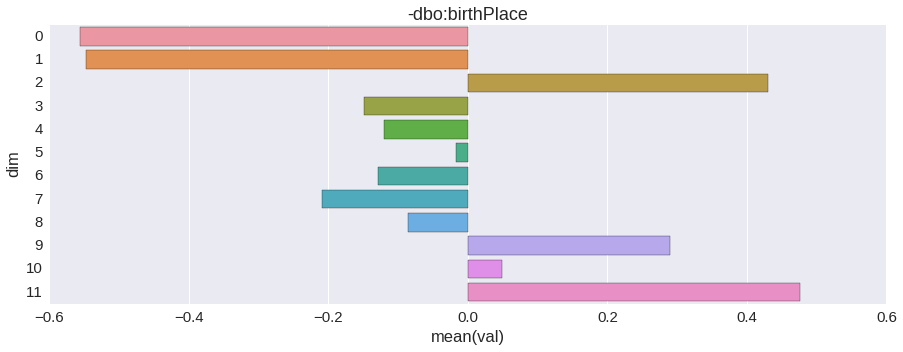

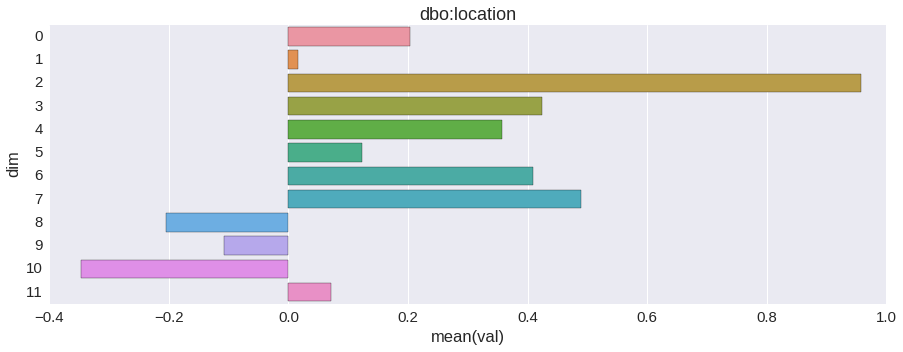

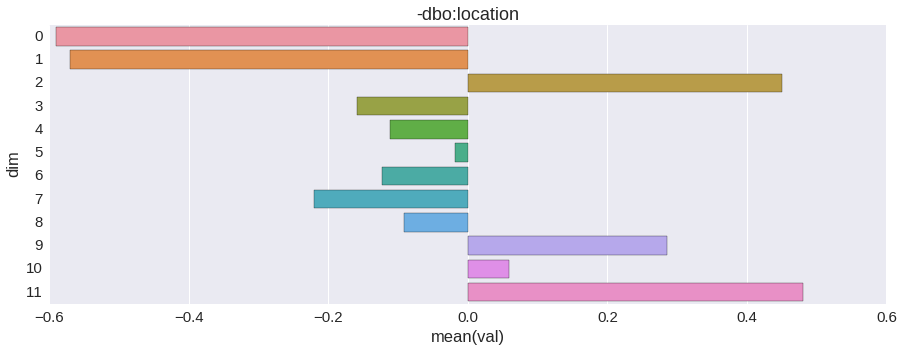

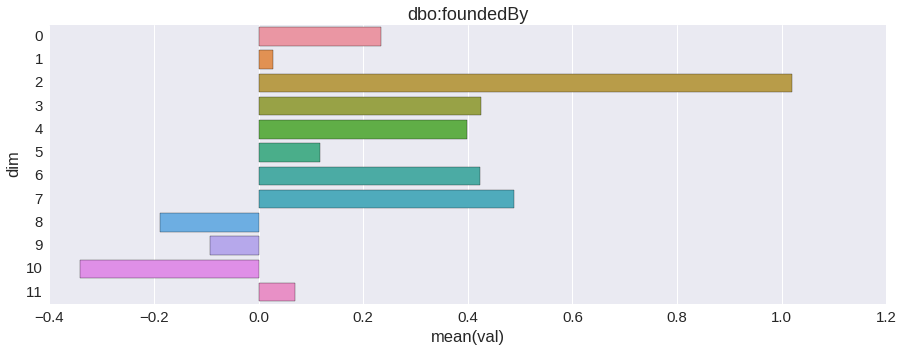

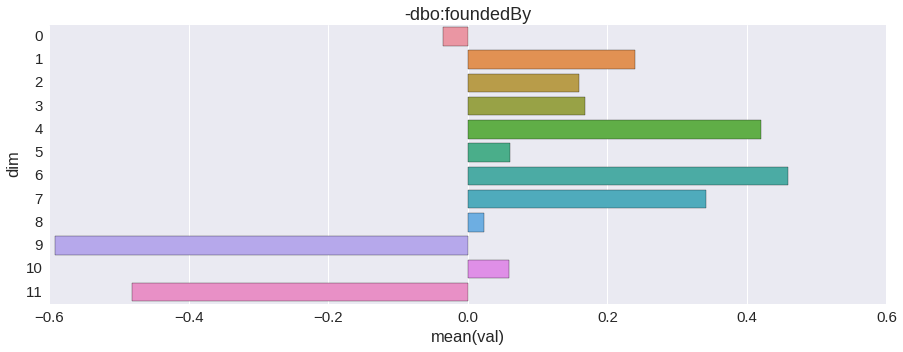

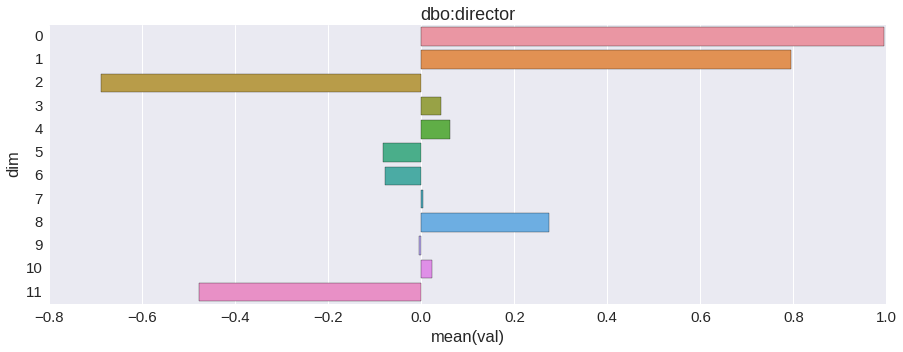

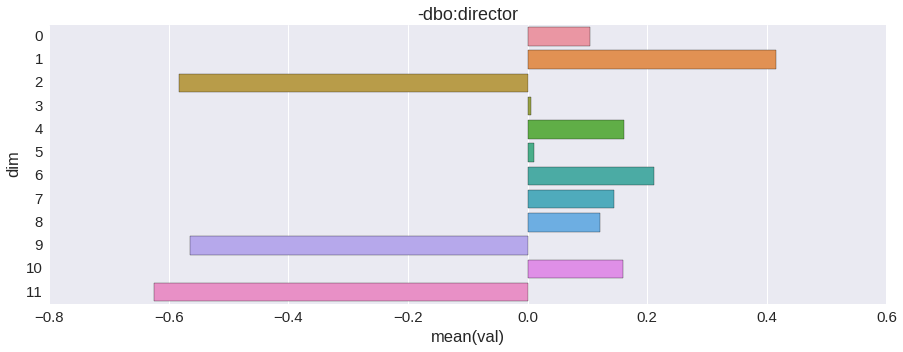

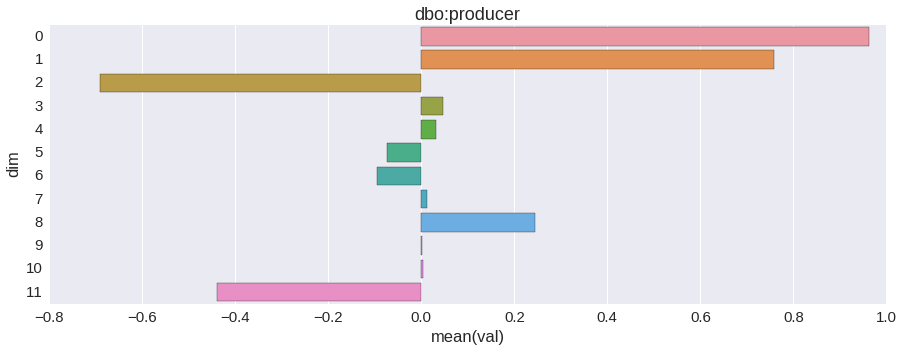

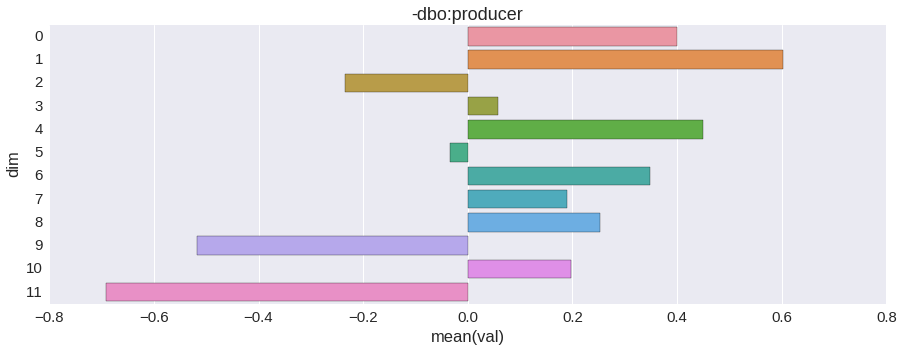

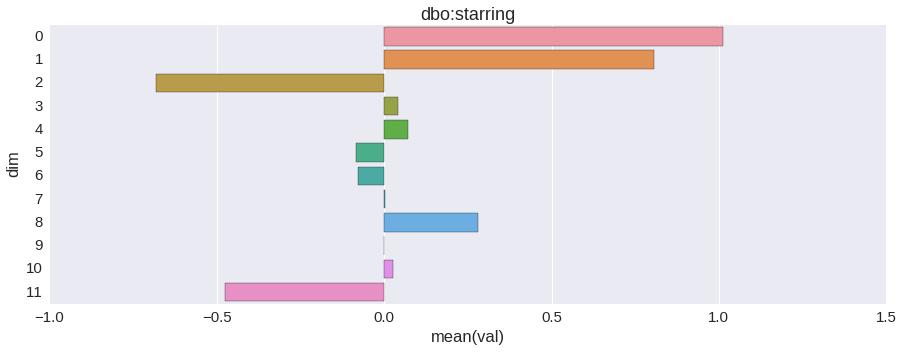

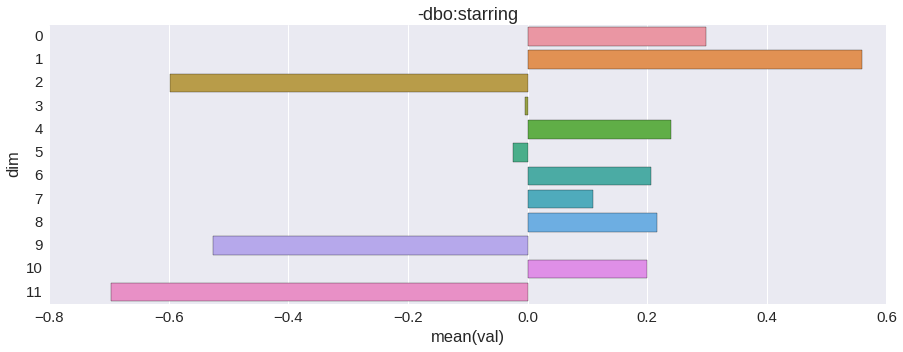

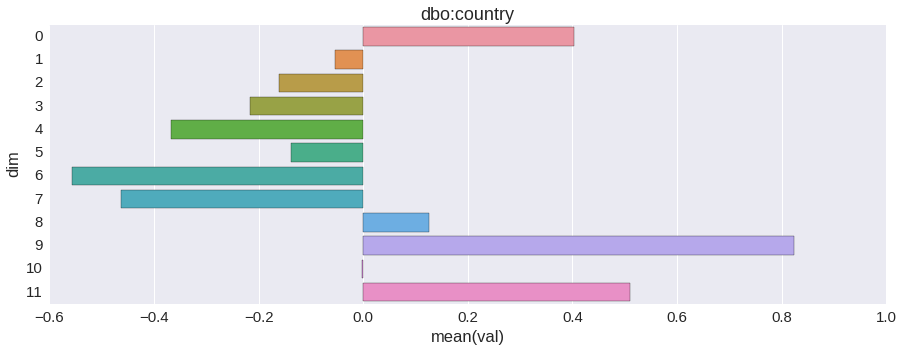

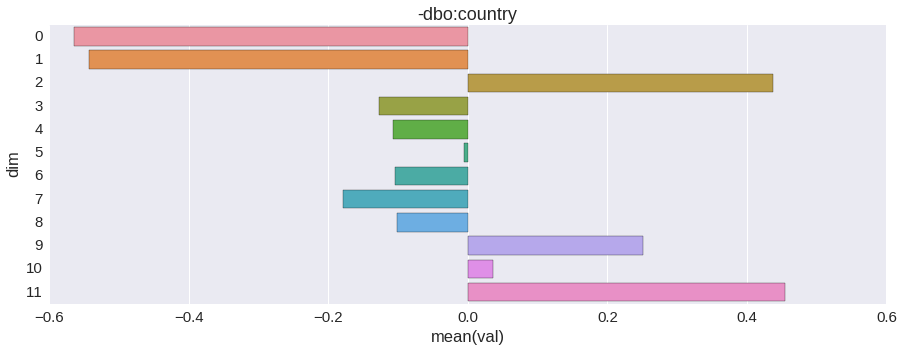

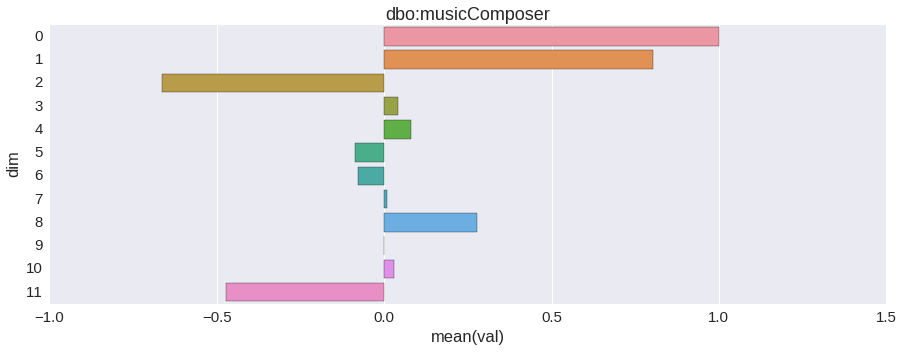

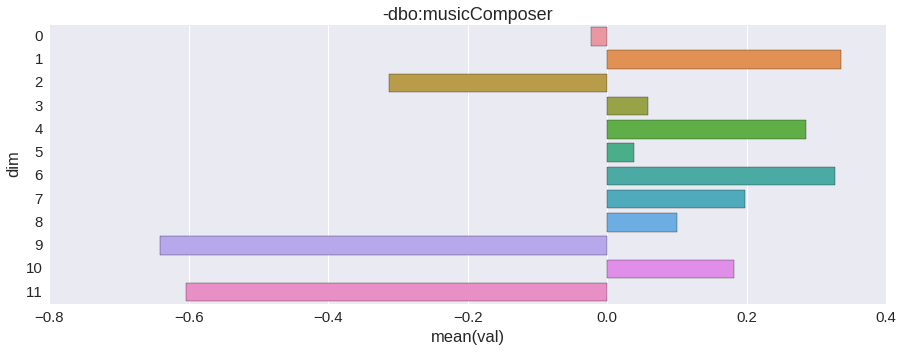

In [216]:
for ent in rels:
    entemb = m.embedY(yd[dopre(ent, prefixes)])
    entembdf = pd.DataFrame(zip(range(len(entemb)), entemb), columns=["dim", "val"])
    f, ax = plt.subplots(figsize=(15,5))
    ax.set_title(ent)
    sns.barplot(x="val", y="dim", data=entembdf, ax=ax, orient="h")